In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from classes.AlexNet import AlexNet
from utils.functions import *
from utils.dataset_loader import *
from utils.train import handle_train

Definição das variaveis gerais

In [2]:
# Número de épocas
NUM_EPOCHS = 2
# Tamanho do lote em cada interação
BATCH_SIZE = 32
# Parâmetro de convergência
MOMENTUM = 0.9 
# Taxa de decaimento
LR_DECAY = 0.0005 
# Taxa de aprendizado inicial
LR_INIT = 0.01 
# Dimensão das imagens
IMAGE_DIM = 227
# Lista de classes do dataset
CIFAR10_CLASSES = ['Santa', 'Not Santa']
# Total de classes
NUM_CLASSES = len(CIFAR10_CLASSES)
# Porcentagem total do dataset
PERCENT = 50

Seleciona em qual dispositivo será executado

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Tranformações para redimensionamento das imagens

In [4]:
# Defina as transformações para redimensionar e normalizar as imagens
transform = transforms.Compose([transforms.Resize((IMAGE_DIM, IMAGE_DIM)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Gera um conjunto de treinamento e de test

In [5]:
# trainset, testset = load_cifar10(n_size=PERCENT, transform=transform)
# # Defina o dataloader
# trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
# testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

train_mother_path = './data/is that santa/train'
test_mother_path = './data/is that santa/train'

train_image_path = glob(os.path.join(train_mother_path, '*', '*'))
test_image_path = glob(os.path.join(test_mother_path, '*', '*'))
trainData = CustomDataset(train_image_path, transform=transform)
testData = CustomDataset(test_image_path, transform=transform)

trainloader = torch.utils.data.DataLoader(trainData,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testData,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

Cria a AlexNet

In [7]:
# Instancie a AlexNet
alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)

Treinmanedo da rede

In [8]:
# Defina a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=LR_INIT, momentum=MOMENTUM, weight_decay=LR_DECAY)

In [9]:
model_trained, metrics = handle_train(alexnet, NUM_EPOCHS, optimizer,criterion,trainloader, testloader, device)

Epoch 0, Testing: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


Epoch 1/2, Training Loss: 0.6933, Test Loss: 0.6907


Epoch 1, Testing: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]

Epoch 2/2, Training Loss: 0.6876, Test Loss: 0.6855


Analise dos resultados pos treinamento

In [10]:
metrics_df = pd.DataFrame(metrics)

In [11]:
metrics_df

,epoch,train_loss,test_loss,accuracy,recall,f1_score
0,1,0.693284,0.690739,0.7443,0.7443,0.732492
1,2,0.687571,0.685525,0.5000,0.5000,0.333333


Evaluating Model:   5%|▌         | 1/20 [00:00<00:03,  6.12it/s]

Evaluating Model: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]
/home/romulolass/Codes/trabalho_pratico_visao_comp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romulolass/Codes/trabalho_pratico_visao_comp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romulolass/Codes/trabalho_pratico_visao_comp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in label

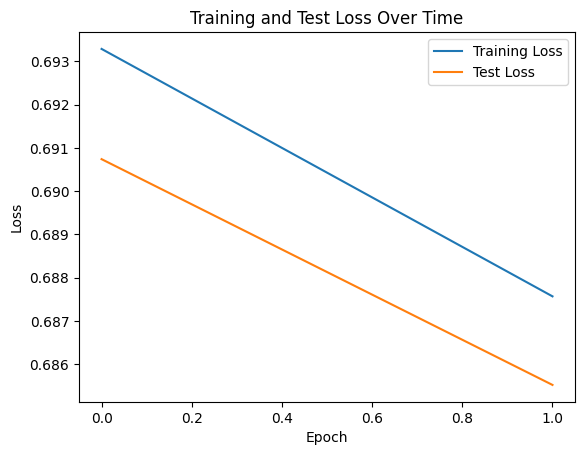

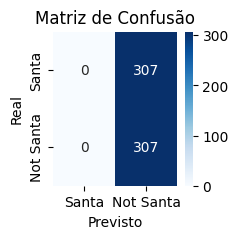

In [12]:
import os
import json
from datetime import datetime


path = './test'
base_name = f'e{NUM_EPOCHS}b{BATCH_SIZE}class{NUM_CLASSES}'
# Adicionando a data e hora ao nome da pasta
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
folder = f'{path}/{base_name}_{current_time}'

os.makedirs(folder, exist_ok=True)


info = {
'epoca': NUM_EPOCHS,
'lote': BATCH_SIZE,
'momento': MOMENTUM,
'decaimento': LR_DECAY,
'tx_inical': LR_INIT,
'dimensao': IMAGE_DIM,
'classes': CIFAR10_CLASSES,
'total_classes': NUM_CLASSES,
'porcentagem': PERCENT,
}

# Plote gráficos de perda
plt.plot(metrics_df['train_loss'], label='Training Loss')
plt.plot(metrics_df['test_loss'], label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.savefig(f'{folder}/loss_over_time.png')


fig, ax, report = evaluate_model(model_trained, testloader, CIFAR10_CLASSES, device)
report_df = pd.DataFrame(report).T


with open(f'{folder}/info.json', 'w') as json_file:
    json.dump(info, json_file, indent=2)


report_df.to_csv(f'{folder}/report.csv')

plt.savefig(f'{folder}/confusion_matrix.png')